# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.shape[0]
n_features = student_data.shape[1]-1
n_passed = (student_data['passed']=="yes").sum()
n_failed = (student_data['passed']=="no").sum()
grad_rate = (n_passed / float(n_passed + n_failed)) * 100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In order to split the data I have used the StratifiedShuffleSplit.
It is a random permutation cross-validation iterator. It generates indices to split data into training and test sets.
This type of split is useful when the target variable is unevenly distributed. This would be helpful in our dataset as our dataset is relatively small.


In [6]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
from sklearn.cross_validation import StratifiedShuffleSplit

splitGen = StratifiedShuffleSplit(y=y_all, 
                                        n_iter=3,
                                        train_size=num_train,
                                        test_size=num_test,
                                        random_state=42)
train_index, test_index = next(iter(splitGen))
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train = X_all.iloc[train_index]
y_train = y_all.iloc[train_index]
X_test = X_all.iloc[test_index]
y_test = y_all.iloc[test_index]
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


###Visualize the basic data

#### We explore that data a little further for better understanding of the data.

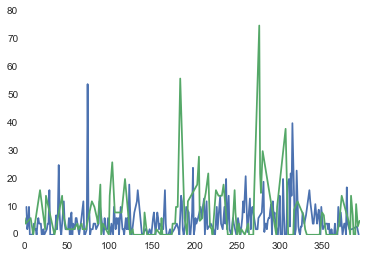

In [7]:
%matplotlib inline
student_data[student_data['passed'] == 'yes']['absences'].plot()
student_data[student_data['passed'] == 'no']['absences'].plot()

In [9]:
feature_full_names = {"school": "student's school",
                      "sex": "student's sex",
                      "age": "student's age",
                      "address": "student's home address type",
                      "famsize": "family size",
                      "Pstatus": "parent's cohabitation status",
                      "Medu": "mother's education",
                      "Fedu": "father's education",
                      "Mjob": "mother's job",
                      "Fjob": "father's job",
                      "reason": "reason to choose this school",
                      "guardian": "student's guardian",
                      "traveltime": "home to school travel time",
                      "studytime": "weekly study time",
                      "failures": "number of past class failures",
                      "schoolsup": "extra educational support",
                      "famsup": "family educational support",
                      "paid": "extra paid classes within the course subject",
                      "activities": "extra-curricular activities",
                      "nursery": "attended nursery school",
                      "higher": "wants to take higher education",
                      "internet": "Internet access at home",
                      "romantic": "with a romantic relationship",
                      "famrel": "quality of family relationships",
                      "freetime": "free time after school",
                      "goout": "going out with friends",
                      "Dalc": "workday alcohol consumption",
                      "Walc": "weekend alcohol consumption",
                      "health": "current health status",
                      "absences": "number of school absences",
                      "passed": "did the student pass the final exam"}

In [10]:
X_train_explore = student_data.iloc[train_index]
test_df = X_train_explore.select_dtypes(include=['object'])
count_col= "passed"

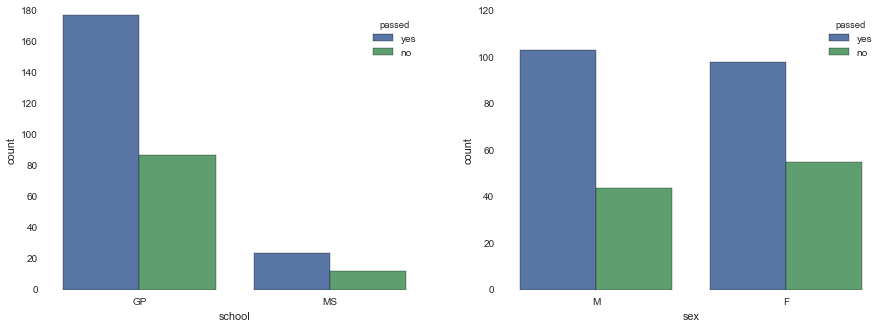

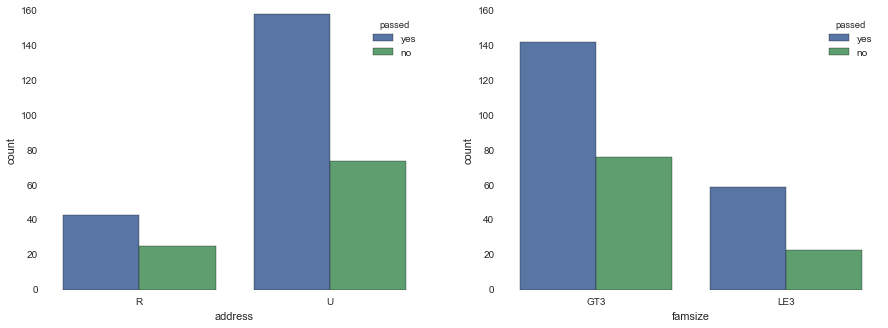

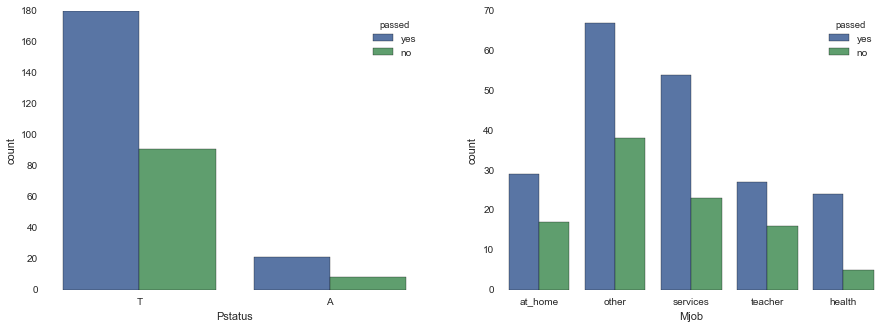

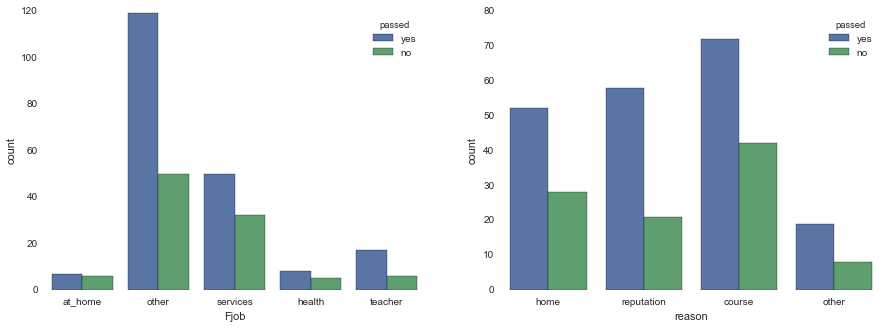

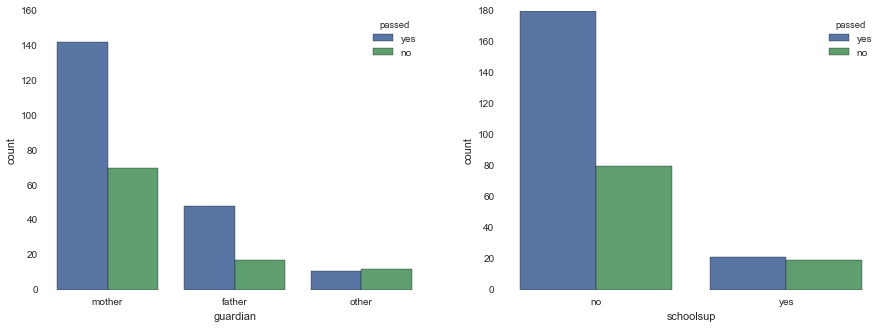

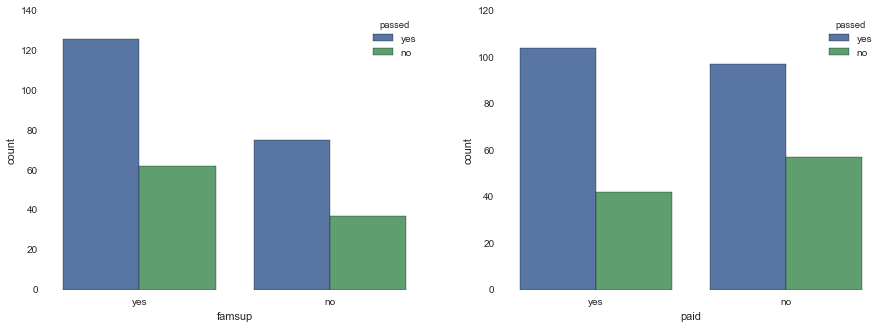

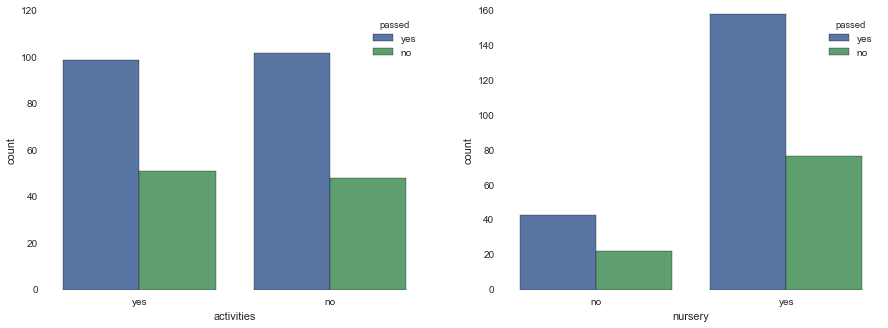

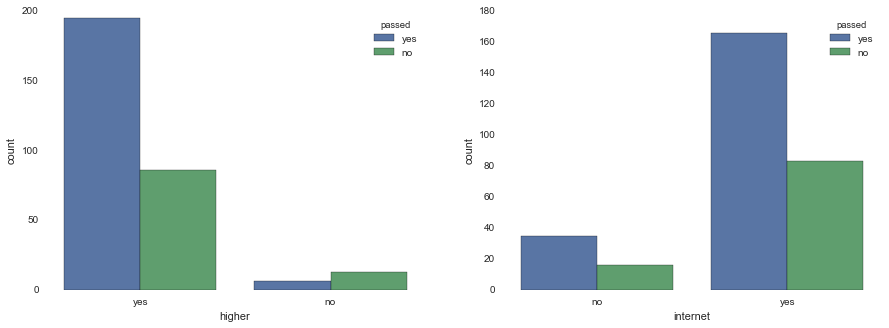

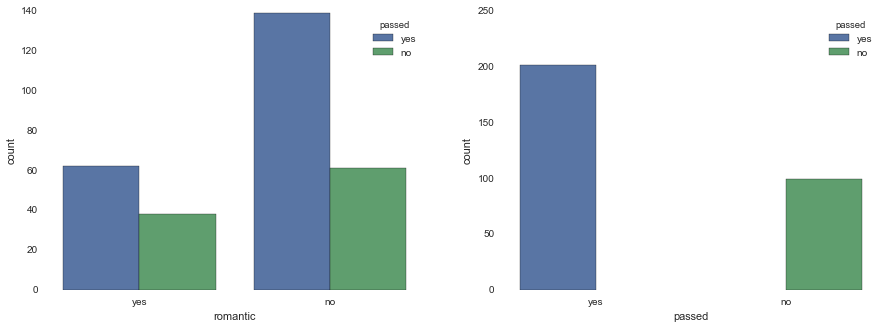

In [11]:
import matplotlib.pyplot as plt
for i, col in enumerate(test_df.columns):
    plot_index = i%2
    #f, axes = plt.subplots(figsize=(18, 5))
    #sns.despine(left=True)
    
    if plot_index ==0:
        f, axes = plt.subplots(1, 2, figsize=(15, 5))
        sns.despine(left=True)
    #print i, col
    
    sns.countplot(data=test_df, x=col,hue=count_col, ax=axes[plot_index])

In [12]:
test2_df =  X_train_explore.select_dtypes(exclude=['object'])
test2_df = test2_df.join(X_train_explore['passed'])

C:\Users\aw634c\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


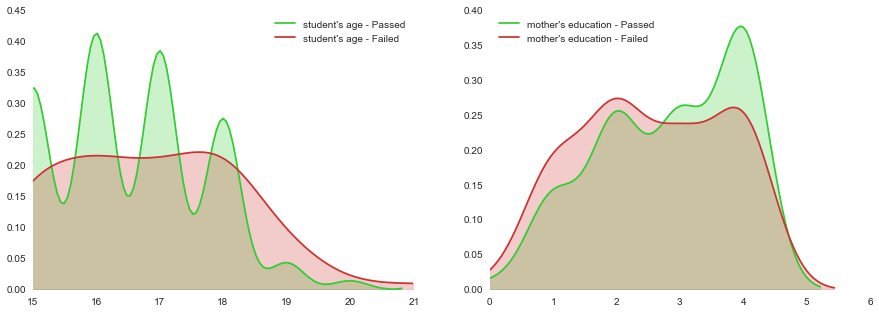

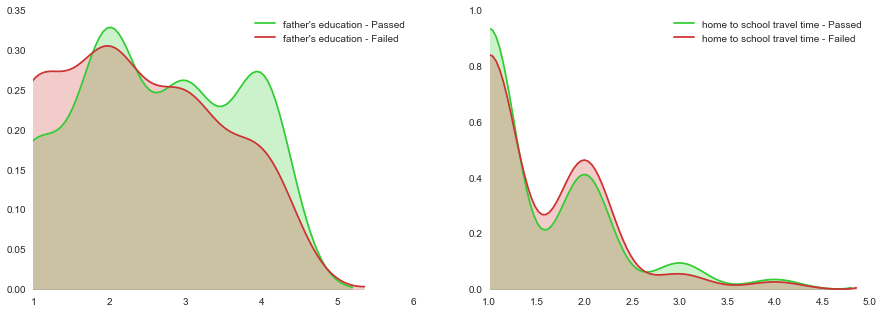

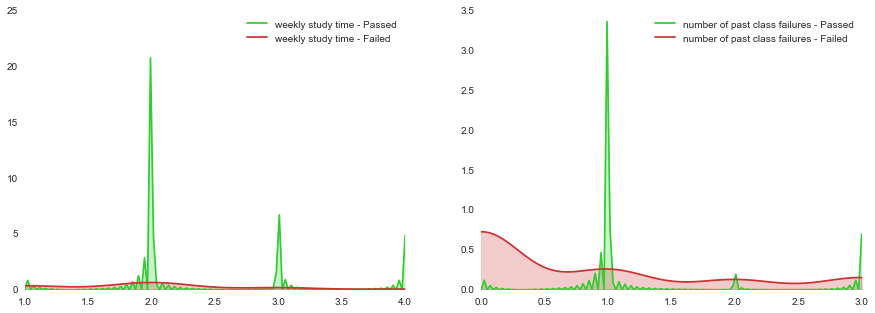

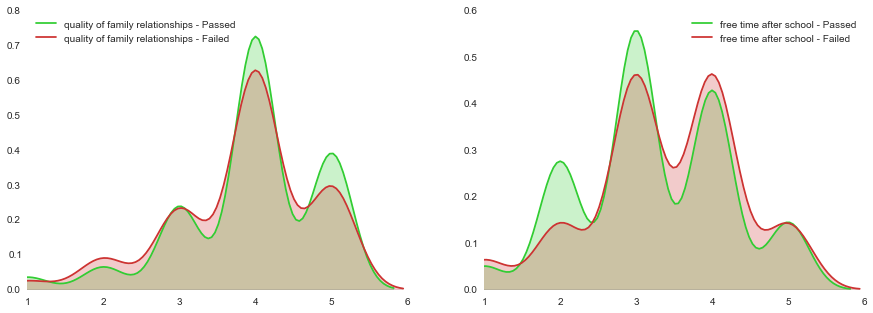

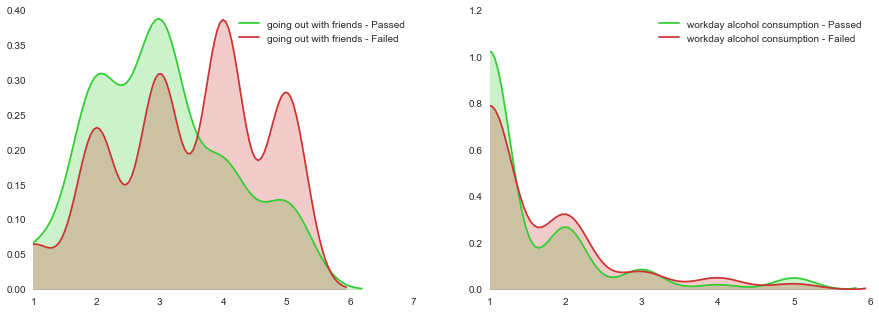

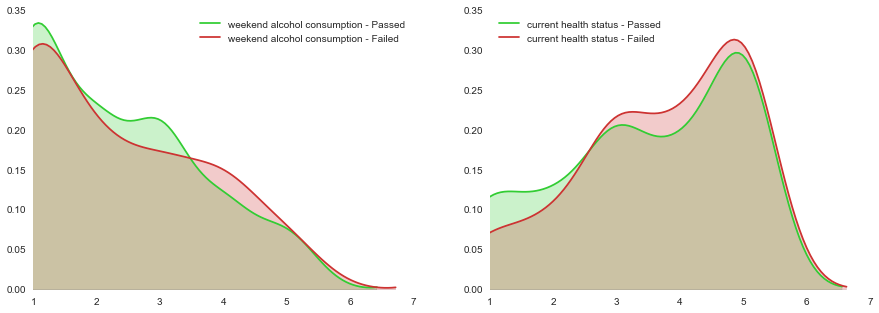

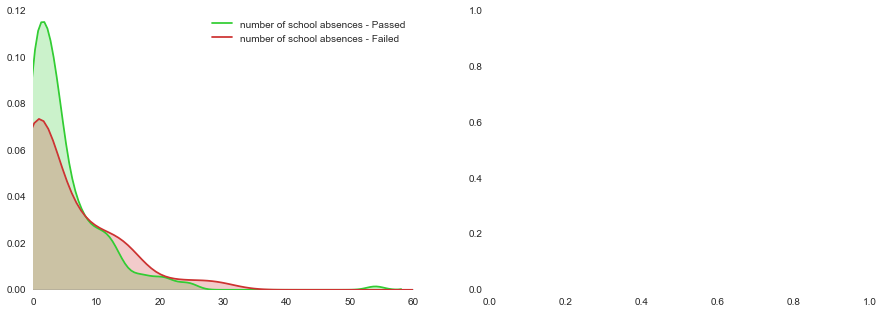

In [13]:
factor_col='passed'


plots_per_row =2
for i, col in enumerate(test2_df.columns):
    plot_index = i%2
    if col == factor_col:
        continue
    #f, axes = plt.subplots(figsize=(18, 5))
    #sns.despine(left=True)
    
    if plot_index ==0:
        f, axes = plt.subplots(1, plots_per_row, figsize=(15, 5))
        sns.despine(left=True)
    #print i, col
        
    pass_yes = test2_df.loc[test2_df[factor_col] == "yes"]
    yes_label = '{0} - Passed'.format(feature_full_names[col])
        
    pass_no = test2_df.loc[test2_df[factor_col] == "no"]
    no_label = '{0} - Failed'.format(feature_full_names[col])

        # Plot each kernel density plot and overlay them.
    sns.kdeplot(pass_yes[col],
                    ax=axes[plot_index], 
                    shade=True,
                    label=yes_label, 
                    color='#32cd33').set(xlim=(min(pass_no[col]))) # Limit the x-label to the min.
        
    sns.kdeplot(pass_no[col],
                    ax=axes[plot_index], 
                    shade=True, 
                    label=no_label,
                    color='#cd3332').set(xlim=(min(pass_no[col])))

## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

##Logistic Regression
Logistic regression is classification machine learning algorithm. Logistic regression measures the relationship between the categorical dependent variable (y) and one or more independent variables (X) by estimating the probabilities using logistic function (ex- sigmoid curve) which is the cumulative logistic distribution. The dependent variable (y) is a discrete variable (0 or 1), called the class. The estimated probabilities is used to predict a given example or given independent variables whether the example belongs to class "1" or class "0". The 2 class of "0" or "1" belongs to the binary classification problems. The logistic regression model can be used for multi class claification also.

###Logistic Function or Sigmoid Function
The logistic function or logistic curve also called sigmoid curve is used to estimating the probabilities for logistic regression model. The equation for a sigmoid function is given below.

$f(x) = \frac{1}{1+exp^(-x)}$


###Estimating conditional Probability with Logistic Function

$$
P(y_i | \mathbf{x}_i,\mathbf{\theta}) = \frac{1}{1 + \exp(-\mathbf{\Theta}^T (\mathbf{x}_i))}
$$

### Strengths

Logistic regression is one of widely used classification model.
- Logistic Regression is very straightforward and easy to implement.
- Logistice Regression being a linear classifier works well with high dimensional data.
- Logistic Regression along with regulization is a convex function. This convexity ensures there are no local minima.
- Convexity of the function ensures convergence, that is solution is fast.


###Weakness
- Logistic Regression works well for discrete outcomes but not for continuous outcomes.
- Each data points in Logistic Regression needs to be independent of other data points. 
- Logistic Regression models are vulnerable to overfitting.
- Logistic Regression requires a lot of data.
- Data needs to be normalized for convergence.

### Applications Of Logistic Regression

Logistic Regression models are used 
- Credit Scoring Models.
- Sentiment Classifier.
- Marketing Campaigns.
- Image Classifications.

##Decision Trees
Decision Tree learning model is a learning algorithm that can be used for classification or regression. Decision tree models are represent an inverted tree, where each branch represents outcome of the logical results(yes/no) and each leaves represent the values of the labels. Topmost node of the inverted tree is called the root node.
The different metrics used in decision trees are

- Gini Impurity
- Information Gain
- Classification Error

Decision Tree models predicts the value of the dependent variable discrete or continous. 

### Strengths
- Decision Trees are simple to understand and interpret.
- Decision Trees does not need a lot of data as compared to Logistic Regression.
- Data does not need to be normalized.
- Decision Trees can be used to predict both discrete (class lables) or coontinous values.

###Weakness
- Decision Trees tend to overfit the data.
- Decision Trees works well on training data but poorly on test data due to overfitting.
- Pruning and Boosting techniques used to prevent overfiting by Decision Tree Learning Models.

### Applications Of Decision Trees

Decision Tree models are used 
- Credit Scoring Models and Financila Analysis.
- Medical Diagnosis.
- Control Systems.
- Object Recognition (Kinect).
- Text Classification.
- Sentiment Analysis.

##Support vector Machines (SVM)
Support Vector Machines are learning models that can be used for classification or regression. SVMs are non-probablistic learning models that categorizes a data point into oone or the other category. SVMs are capable of doing linear classification as well as non-linear classification. Non-linear classification is done by using kernels. Gaussian kernel is one of the most comonly used kernels. SVMs are also called large margin classifiers.
SVMs gives a direct prediction of the lables (0/1 in binary classifiers) as compared to the logistic regression which is probablistic model.


### Strengths
- SVMs works very well on data that are not lineraly separable.
- SVMs are not affected by local minima as compared to Logistic Regression.
- SVMs works very well with high dimesnional data and does not suffer the curse of dimensionality.
- SVMs can be applied for a classification or regression problem.
- SVMs Convex Optimization function gurantees convergence to global slution.



###Weakness
- SVMs are very sensitive to noise.
- Mislabelled examples will decrease the performance.
- Choice of Kernel(Gaussian, Polynomial etc). 
- Kernel parameters required to fine tune the SVMs model and this is a time consuming process.

### Applications Of Decision Trees

Decision Tree models are used 
- Image Classification
- Medical Diagnosis(cancer classification).
- Bioinformatics(Protein Classification).
- Character Recognition(Hand writting).
- Text Classification.
- Sentiment Analysis.




Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [14]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    return (end-start)
    
# TODO: Choose a model, import it and instantiate an object
from sklearn import svm
clf = svm.SVC(kernel='rbf')

# Fit model to training data
trainTime =train_classifier(clf, X_train, y_train)  # note: using entire training set here
print clf  # you can inspect the learned model by printing it
print "Training time (secs): {:.3f}".format(trainTime)

Training SVC...
Done!
Training time (secs): 0.006
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Training time (secs): 0.006


In [15]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score
import time

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes'), (end-start)

train_f1_score, predictTime = predict_labels(clf, X_train, y_train)
#predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)
print "Prediction time (secs): {:.3f}".format(predictTime)

Predicting labels using SVC...
Done!
Prediction time (secs): 0.005
F1 score for training set: 0.866379310345
Prediction time (secs): 0.005


In [16]:
# Predict on test data

print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test)[0])

Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.805194805195


In [17]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    #trainTime = train_classifier(clf, X_train, y_train)
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train)[0])
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test)[0])
    train_f1_score, predictTimeTrain = predict_labels(clf, X_train, y_train)
    test_f1_score, predictTimeTest = predict_labels(clf, X_test, y_test)
    
    F1_scores = {'F1_train': train_f1_score,
                 'F1_test': test_f1_score}
    
    timeTaken = {'Training Time': trainTime,'Predict Train Time': predictTimeTrain,'Predict Test Time': predictTimeTest}
    
    return F1_scores, timeTaken

setSize =[100,200,300]
#Reference Stack Flow

rowList =[]
# TODO: Run the helper function above for desired subsets of training data
for size in setSize:
    splitGen = StratifiedShuffleSplit(y=y_all, 
                                        n_iter=3,
                                        train_size=size,
                                        test_size=num_test,
                                        random_state=42)
    train_index, test_index = next(iter(splitGen))
    X_train = X_all.iloc[train_index]
    y_train = y_all.iloc[train_index]
    X_test = X_all.iloc[test_index]
    y_test = y_all.iloc[test_index]
    #X_train, X_test1, y_train, y_test1= train_test_split(X_all,y_all,train_size= size, random_state=42)
    F1_scores, predicttime = train_predict(clf, X_train, y_train, X_test, y_test)
    print size
    one_row ={"Training Size":size}
    one_row.update(F1_scores)
    one_row.update(predicttime)
    
    rowList.append(one_row)
    #dfTest.from_dict
    #print F1_scores, predicttime
# Note: Keep the test set constant
print "________________________________________________________________________________________________"
print clf
svmModel= pd.DataFrame(rowList)
svmModel

------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.001
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.864516129032
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.81045751634
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
100
------------------------------------------
Training set size: 200
Training SVC...
Done!
Training time (secs): 0.003
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.861736334405
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.823529411765
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
200
------------------------------------------
Training set size: 300

,F1_test,F1_train,Predict Test Time,Predict Train Time,Training Size,Training Time
0,0.810458,0.864516,0.001,0.001,100,0.006
1,0.823529,0.861736,0.002,0.003,200,0.006
2,0.805195,0.866379,0.002,0.005,300,0.006


In [18]:
# TODO: Train and predict using two other models
#Decision Tree Classifier. Use Decision Tree to classify the data
from sklearn import tree
clfTree = tree.DecisionTreeClassifier()
modelRow={}
rowList =[]
for size in setSize:
    splitGen = StratifiedShuffleSplit(y=y_all, 
                                        n_iter=3,
                                        train_size=size,
                                        test_size=num_test,
                                        random_state=42)
    train_index, test_index = next(iter(splitGen))
    X_train = X_all.iloc[train_index]
    y_train = y_all.iloc[train_index]
    X_test = X_all.iloc[test_index]
    y_test = y_all.iloc[test_index]
    #X_train, X_test1, y_train, y_test1= train_test_split(X_all,y_all,train_size= size, random_state=42)
    F1_scores, predicttime = train_predict(clfTree, X_train, y_train, X_test, y_test)
    print size
    modelRow ={"Training Size":size}
    modelRow.update(F1_scores)
    modelRow.update(predicttime)
    
    rowList.append(modelRow)
    #dfTest.from_dict
    #print F1_scores, predicttime
# Note: Keep the test set constant
print "________________________________________________________________________________________________"
print clfTree
TreeModel=pd.DataFrame(rowList)
TreeModel

------------------------------------------
Training set size: 100
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.001
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 1.0
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.740157480315
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
100
------------------------------------------
Training set size: 200
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.001
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set: 1.0
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.765625
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs)

,F1_test,F1_train,Predict Test Time,Predict Train Time,Training Size,Training Time
0,0.740157,1,0.000,0,100,0.006
1,0.765625,1,0.001,0,200,0.006
2,0.710744,1,0.000,0,300,0.006


In [19]:
#Create a Clssifier Using Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

clfLogReg = LogisticRegression(penalty='l1')
modelRow={}
rowList =[]
for size in setSize:
    splitGen = StratifiedShuffleSplit(y=y_all,n_iter=3,train_size=size,test_size=num_test,random_state=42)
    train_index, test_index = next(iter(splitGen))
    X_train_scaled = X_all.iloc[train_index]
    y_train_scaled = y_all.iloc[train_index]
    X_test_scaled = X_all.iloc[test_index]
    y_test_scaled = y_all.iloc[test_index]
    #X_train, X_test1, y_train, y_test1= train_test_split(X_all,y_all,train_size= size, random_state=42)
    F1_scores, predicttime = train_predict(clfLogReg, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
    print size
    modelRow ={"Training Size":size}
    modelRow.update(F1_scores)
    modelRow.update(predicttime)
    
    rowList.append(modelRow)
    #dfTest.from_dict
    #print F1_scores, predicttime
# Note: Keep the test set constant
print "________________________________________________________________________________________________"
print clfLogReg
logRegModel =pd.DataFrame(rowList)
logRegModel

------------------------------------------
Training set size: 100
Training LogisticRegression...
Done!
Training time (secs): 0.002
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.007
F1 score for training set: 0.895104895105
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.755555555556
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
100
------------------------------------------
Training set size: 200
Training LogisticRegression...
Done!
Training time (secs): 0.004
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.842465753425
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.814285714286
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000


,F1_test,F1_train,Predict Test Time,Predict Train Time,Training Size,Training Time
0,0.755556,0.895105,0,0.000,100,0.006
1,0.814286,0.842466,0,0.000,200,0.006
2,0.753623,0.832952,0,0.001,300,0.006


In [20]:
#Support Vector Machine Model
svmModel

,F1_test,F1_train,Predict Test Time,Predict Train Time,Training Size,Training Time
0,0.810458,0.864516,0.001,0.001,100,0.006
1,0.823529,0.861736,0.002,0.003,200,0.006
2,0.805195,0.866379,0.002,0.005,300,0.006


In [21]:
#Decision Tree Model
TreeModel

,F1_test,F1_train,Predict Test Time,Predict Train Time,Training Size,Training Time
0,0.740157,1,0.000,0,100,0.006
1,0.765625,1,0.001,0,200,0.006
2,0.710744,1,0.000,0,300,0.006


In [22]:
#Logistic Regression Model
logRegModel

,F1_test,F1_train,Predict Test Time,Predict Train Time,Training Size,Training Time
0,0.755556,0.895105,0,0.000,100,0.006
1,0.814286,0.842466,0,0.000,200,0.006
2,0.753623,0.832952,0,0.001,300,0.006


## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

Based on the three models used for classification F1 scores obtained from Support vector Machine and Logistic Regression were 
identical. Hence Grid Search CV was used to fine tune the model for the support vector machine and logistic regression.

In [23]:
# TODO: Fine-tune your model and report the best F1 score
from sklearn import grid_search
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit



cv = StratifiedShuffleSplit(y_train, random_state=42)

clf = svm.SVC()
param_grid = [
  {'C': [1, 10, 100, 200, 300, 400, 500, 600, 700],
   'gamma': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
   'kernel': ['rbf'], 'tol':[1e-3, 1e-4, 1e-5, 1e-6]
  }
 ]

regressor = grid_search.GridSearchCV(clf, param_grid,cv=cv, scoring='f1_weighted')
regressor.fit(X_train, y_train)
reg = regressor.best_estimator_
print reg
train_f1_score = predict_labels(reg, X_train, y_train)[0]
print "F1 score for training set: {}".format(train_f1_score)

print "F1 score for test set: {}".format(predict_labels(reg, X_test, y_test)[0])

SVC(C=300, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.900943396226
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.739130434783


C:\Users\aw634c\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
from sklearn import grid_search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = grid_search.GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
regressor_LogReg = grid_search.GridSearchCV(cv=cv,
       estimator=LogisticRegression(C=1.0, intercept_scaling=1, dual=False, fit_intercept=True,
          penalty='l2', tol=0.0001),
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
regressor_LogReg.fit(X_train_scaled, y_train_scaled)
regLogRef = regressor_LogReg.best_estimator_
print regLogRef
train_f1_score_LogReg = predict_labels(reg, X_train_scaled, y_train_scaled)[0]
print "F1 score for training set: {}".format(train_f1_score_LogReg)

print "F1 score for test set: {}".format(predict_labels(regLogRef, X_test_scaled, y_test_scaled)[0])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.900943396226
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.777777777778


### Choice of the Best Model

Both Support Vector machine and the logistic regression claasification models showed improvement in the F1 scores after Grid Search Model. 

A F1 score of 0.90 was obtained using the SVM on the train data and 0.74 on the test data.

A F1 score of 0.90 was obtained using the logitic regression model on the train data and 0.78 on the test data.

SVM and Logistic Regression took almost the same time to train and test the data.

Based on the analysis Logistic Regression with L2 penalty provides the best model in predicting the graduation rates of the students.

The Logistic Regression model multiplies the variables with the weights obtained into a final score. This final score we get is between 0 and 1. This value of  between 0 and 1 gives the probability of the student passing.

If the score or the probablity is greater than 0.5 the probability, the model predicts tha the student will pass and if not the model predicts the student fails.

The final tuned F1 score on the test set using Logistic Regression with L2 penalty is 0.78.